<h1>The travelling salesman problem with genetic algorithms</h1>

The travelling salesman problem is a combinatorial optimization problem. I introduced the problem in <a href="">this notebook</a>, where I solved the optimization problem using Simulated Annealing. Here we want to solve the problem using a different heuristic approach, namely Genetic Algorithms.

Again, let's suppose we want to go on vacation in Italy and visit some of its cities. Suppose these cities are the ones represented with red dots in the following map:

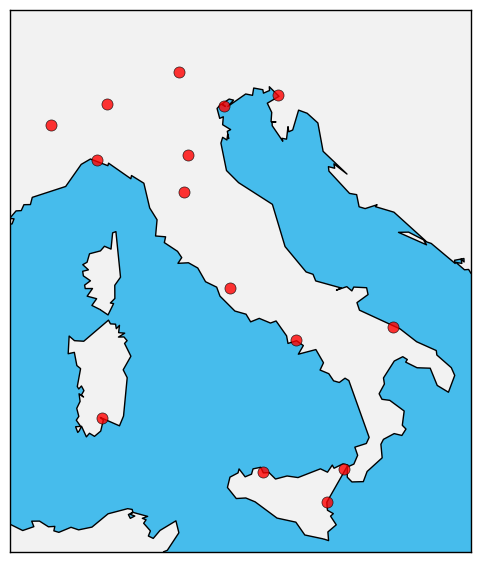

In [1]:
from IPython.display import Image
url = 'https://raw.githubusercontent.com/mirkomiorelli/Machine_Learning/master/IMAGES/Italy_simann.png'
Image(url,width=300, height=300)

Now we want to find the best path between these cities, with "the best" meaning the shortest one (taking planes). You realize we have many possible paths connecting all these cities (the number of paths grows factorially with the number of cities), and so we need some efficient way to explore the configuration space (the space of all the possible paths).

Following the notation of my previous notebook on the traveling salesman problem with simulated annealing, What we want to minimize is the total length of the path $L(s)$ obtained as:
\begin{align}
L(s) = \sum_{j>i=1}^N s_{ij},
\end{align}
where we denote with $\{c_i\}_{i=1,...,N}$ the set of N cities, and $s_{ij}$ isthe segment between city $c_i$ and city $c_j$. Here, $s$ represents a state in the configuration space of the paths, <i>i.e.</i>, a possible path through the cities which has length $L(s)$.


The idea of genetic algorithms is to start with a number of randomly selected states of the configuration space (population). For each one of these states (chromosomes) we calculate the length of the path (fitness) and then we select the states with the shortest path (for example the half with shortest paths) and combine them (crossover) to generate new states in the configuration space. We then repeat the above steps (calculate fitness and crossover to generate new states) iteratively a certain number of times (generations) or until convergence on the path length is reached.

Following the above procedure, we end up with a population of states which will have, on average, shortest paths lengths than the first selection of states. In other words, the population will evolve so that only the configurations with shortes path (or better fitness) will eventually survive in the last generation.

In particular, we can plot the average length of the path as the system evolves, <i>i.e.</i> as we move from generation to generation. Such a plot would look like:

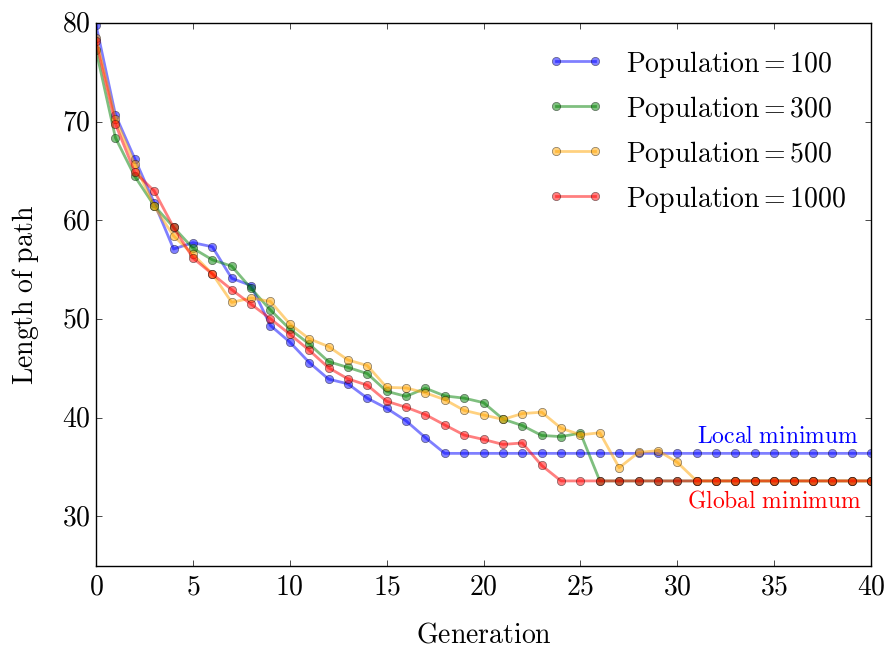

In [2]:
from IPython.display import Image
url = 'https://raw.githubusercontent.com/mirkomiorelli/Machine_Learning/master/IMAGES/ga_pathvspop.png'
Image(url,width=500, height=500)

In the above graph it is easy to see that as the system "evolves", the average length of the path of the population decreases. It is also interesting to see that if we start with a small population, we might get stuck in a local optimum of the configuration space. This effect would be more noticeable when we have a lot of cities in out optimization problem (since the configuration space landscape becomes more complex). We can partly attempt to solve this problem by supplementing the genetic algorithm with a "mutation" step, where at each generation we randomly select some of the chromosomes in the population and we slighlty modify them (for example by exchanging two cities along the path). If we do this, what we obtain might look like

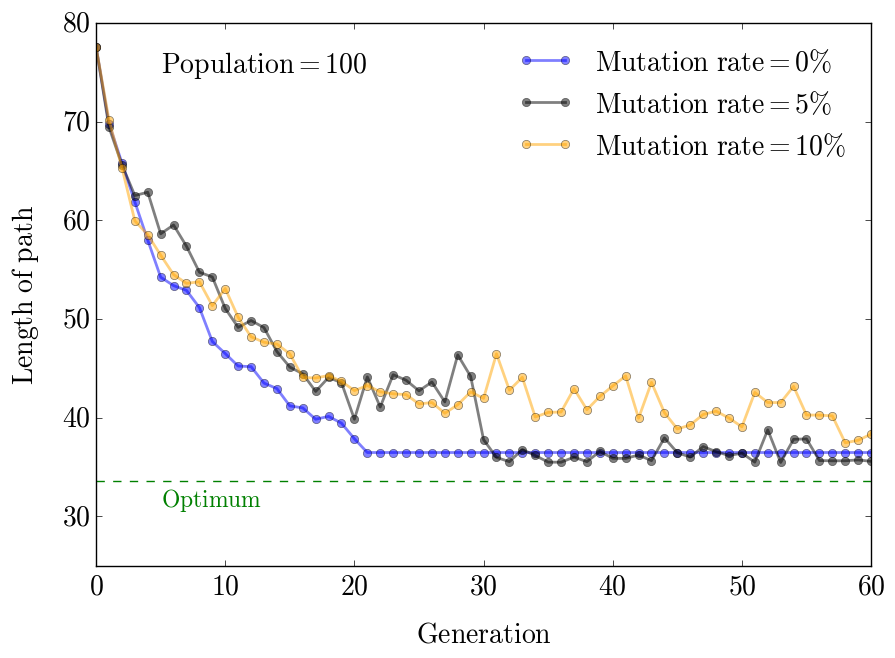

In [3]:
from IPython.display import Image
url = 'https://raw.githubusercontent.com/mirkomiorelli/Machine_Learning/master/IMAGES/ga_mutationeffect.png'
Image(url,width=500, height=500)

By mutating 5% of the chromosomes in each generation, we find that we converge to a length of the path which is a bit closer to the global optimum. However, as we increase the mutation rate, our results deteriorate since we are contaminating the "best" chromosomes (the ones which we would use for the crossover) with frequent random mutations.

The hard part in implementing a genetic algorithm for a certain problem is to come up with a sensible choice for the crossover step, <i>i.e.</i> the step where we combine two configurations to obtain a new one. The crossover should resemble chromosomes recombination, where the child chromosome should contain some of the traits of the parent chromosomes. For the traveling salesman problem, there's various recombination techniques that can be used. Here I chose to use the one called <i>Edge Recombination</i> (ER) from J.Y. Potvin <a href="https://iccl.inf.tu-dresden.de/w/images/b/b7/GA_for_TSP.pdf">paper</a>. The crossover process is explained very nicely in the paper at pag. 358, so I will not spend time here explaining it again.

<h3> Python implementation</h3>

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from collections import OrderedDict
%matplotlib inline

In [5]:
# Utility functions to read/print data

# Read and transform coordinates from file
def read_map(file_name):
    df = pd.read_csv(file_name)
    lon = []; lat = []
    for i in range(len(df)):
        deg = df.loc[i,'Lon'] - df.loc[i,'Lon'] % 1
        mins = 100.0*(df.loc[i,'Lon'] - deg)
        lon.append(deg + mins / 60.0)
        deg = df.loc[i,'Lat'] - df.loc[i,'Lat'] % 1
        mins = 100.0*(df.loc[i,'Lat'] - deg)
        lat.append(deg + mins / 60.0)
    return df, lon, lat

# Print map of cities function
def print_map(lon,lat,s=[]):
    fig, ax = plt.subplots(figsize=(10,7))
    m = Basemap(resolution='l', # c, l, i, h, f or None
            projection='merc',
            lat_0=10.8, lon_0=12.37,
            llcrnrlon=6.59, llcrnrlat= 36.42, urcrnrlon=18.96, urcrnrlat=47.22)
    m.drawmapboundary(fill_color='#46bcec')
    m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
    m.drawcoastlines()
    for i in range(len(df)):
        x, y = m(lon[i],lat[i])
        m.plot(x, y, 'o', markersize=8, color='red', alpha=0.8)
    x, y = m(lon[s],lat[s])
    m.plot(x,y,lw=2.0,alpha=1.0)
    plt.show()
    return

In [6]:
# Genetic algorithm functions

# Initialize random population
def init_pop(LEN, POP):
    indices = np.arange(LEN)
    chromosomes = np.zeros((POP,LEN),dtype=int)
    for ir in range(POP):
        np.random.shuffle(indices)
        chromosomes[ir,:] = indices
    return chromosomes

# Crossover routines (edge map concept from https://iccl.inf.tu-dresden.de/w/images/b/b7/GA_for_TSP.pdf)

# Calculate edge map given two chromosomes (parents) 
def get_edge_map(LEN, ch1, ch2):
    emap = {}
    for i in range(LEN):
        if i not in emap:
            emap[i] = []
        for j in range(LEN):
            # Check chromosome 1
            if i == ch1[j]:
                if j == 0:
                    emap[i].append(ch1[LEN-1])
                    emap[i].append(ch1[j+1])
                elif j == LEN-1:
                    emap[i].append(ch1[0])
                    emap[i].append(ch1[j-1])
                else:
                    emap[i].append(ch1[j-1])
                    emap[i].append(ch1[j+1])
            # Check chromosome 2
            if i == ch2[j]:
                if j == 0:
                    emap[i].append(ch2[LEN-1])
                    emap[i].append(ch2[j+1])
                elif j == LEN-1:
                    emap[i].append(ch2[0])
                    emap[i].append(ch2[j-1])
                else:
                    emap[i].append(ch2[j-1])
                    emap[i].append(ch2[j+1])
        emap[i] = list(set(emap[i]))
    
    return emap

# Get next gene in the chromosome (see pag.358 of https://iccl.inf.tu-dresden.de/w/images/b/b7/GA_for_TSP.pdf)
def get_next(LEN, off, emap):
    # Get edges for the last index in off
    edges = emap[off[-1]]
    # Loop only over selected edges
    lenmin = None
    for k in emap:
        # Skip if not in edges of the given index
        if k not in edges:
            continue
        if k in off:
            continue
        if lenmin is None:
            lenmin = len(emap[k])
        else:
            if len(emap[k]) < lenmin:
                lenmin = len(emap[k])
    # Now build list of min indices
    if lenmin is not None:
        idxmin = []
        for k in emap:
            # Skip if not in edges of the given index
            if k not in edges:
                continue
            if k in off:
                continue
            if len(emap[k]) == lenmin:
                idxmin.append(k)

        # Random pick the next index from minimum number of edges indices
        nxt = np.random.choice(idxmin)
    else:
    #    # 
        nxt = np.random.choice([i for i in np.arange(LEN) if i not in off])
        
    return nxt

# Generate offspring chromosome from parent chromosomes
def get_offspring(LEN, parent1, parent2):
    # Get edges map
    emap = get_edge_map(LEN, parent1, parent2)
    #print(emap)
    ### Build offspring ###
    # Select randomly first index
    first = parent1[np.random.randint(low=0,high=LEN)]
    off = [first]
    for i in range(1,LEN):
        nxt = get_next(LEN, off, emap)
        off.append(nxt)
    
    return off

# Mutation: swap two genes in a chromosome
def mutate(LEN, ch):
    idx1 = np.random.randint(LEN)
    idx2 = np.random.randint(LEN)
    gen1 = ch[idx1]
    gen2 = ch[idx2]
    ch[idx1] = gen2
    ch[idx2] = gen1
    return ch

# Calculate length of the path 
def get_distance(ch,x,y,LEN):
    # Add length first-last
    l = np.sqrt((x[ch[0]] - x[ch[LEN-1]])**2 + (y[ch[0]] - y[ch[LEN-1]])**2)
    for i in range(LEN-1):
        l += np.sqrt((x[ch[i]] - x[ch[i+1]])**2 + (y[ch[i]] - y[ch[i+1]])**2)
    return l

# Fitness function for the whole population (a list of distances for each chromosome)
def get_fitness(chromosomes, x, y, POP, LEN):
    fit = list(range(POP))
    for ic in range(POP):
        fit[ic] = get_distance(chromosomes[ic, :], x, y, LEN)
    return fit

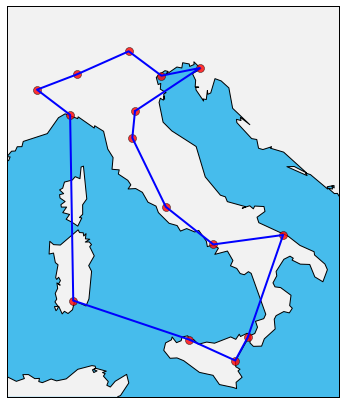

In [7]:
#Generate data (travelling salesman problem)
df, lon, lat = read_map(file_name='../DATASETS/italy_cities.csv')
x = np.array(lon)
y = np.array(lat)
#print_map(x,y)

# Set parameters for the algorithm
GENERATIONS = 40        # Number of iterations
POPULATION = 5000       # Chromosomes population (number of states)
LENGTH = len(df)        # Chromosomes length (number of cities)
CROSSOVER_RATE = 0.3    # Percentage of chromosomes used to generate offspring
MUTATION_RATE = 0.0     # Mutation rate
# Init random seed
np.random.seed(0)

# Initialize population
chromosomes = init_pop(LENGTH, POPULATION) #parents
chromosomes2 = np.zeros(chromosomes.shape,dtype=int) #offspring

# Loop over generations
# Here we keep track of the best chromosome ever (BEST_CH, i.e. the one with the shortest path ever)
fit_pop = []
for g in range(0,GENERATIONS+1):
    if g == 0:
        fit = get_fitness(chromosomes, x, y, POPULATION, LENGTH)
        BEST_CH = chromosomes[np.argmin(fit),:]
    
    # Save average distance of population
    fit_pop.append(np.divide(np.sum(fit),len(fit)))
    
    # Verbose mode
    #print("Generation: ",g)
    #print("Average distance of population: ",fit_pop[g],"\n")
    
    # Order chromosomes based on fitness value (smaller fit value, better since the fit value is distance here)
    idx_ordered = [i[0] for i in sorted(enumerate(fit), key=lambda x:x[1])]
    
    # Crossover (create offspring population from parents)
    for c in range(POPULATION):
        # Select parents on crossover_rate
        parent1 = chromosomes[np.random.choice(idx_ordered[:int(POPULATION * CROSSOVER_RATE)]),:]
        parent2 = chromosomes[np.random.choice(idx_ordered[:int(POPULATION * CROSSOVER_RATE)]),:]
        # Get child
        chromosomes2[c, :] = get_offspring(LENGTH, parent1, parent2)
        # Mutation
        u = np.random.uniform()
        if u <= MUTATION_RATE:
            chromosomes2[c,:] = mutate(LENGTH, chromosomes2[c,:])
    
    # Update new population
    chromosomes = chromosomes2
    
    # Calculate fitness for current generation
    fit = get_fitness(chromosomes, x, y, POPULATION, LENGTH)
    # Save best chromosome
    if min(fit) < get_distance(BEST_CH, x, y, LENGTH):
        BEST_CH = np.copy(chromosomes[np.argmin(fit),:])
    
# Print best path
BEST_CH = list(BEST_CH)
BEST_CH.append(BEST_CH[0])
print_map(x,y,BEST_CH)

The result we obtain is exactly the same we obtained using simulated annealing. 